In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
import sys
from threading import Thread
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:

# pv.set_jupyter_backend('pythreejs')
# pv.set_jupyter_backend('ipygany') # ipygany fails " Failed to use notebook backend: "
# pv.set_jupyter_backend('panel') # Doesn't work either, produces no output
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

In [2]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map

In [3]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \nUpdated sys.path: {}'.format(sys.path))
    from neuropy import core
from neuropy.core.dataSession import DataSession, processDataSession

# basedir = '/media/share/data/Bapun/Day5TwoNovel' # Linux
basedir = 'R:\data\Bapun\Day5TwoNovel' # Windows
# basedir = '/Volumes/iNeo/Data/Bapun/Day5TwoNovel' # MacOS
sess = core.processDataSession(basedir)

neuropy module not found, adding directory to sys.path. 
Updated sys.path: ['C:\\Users\\Pho\\repos\\PhoPy3DPositionAnalysis2021', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\python39.zip', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\DLLs', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\lib', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz', '', 'C:\\Users\\Pho\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\lib\\site-packages', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\lib\\site-packages\\win32', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Pho\\anaconda3\\envs\\phoviz\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Pho\\.ipython', 'C:\\Users\\Pho\\repos\\NeuroPy']
Issue with pickled POSIX_PATH on windows for path R:\data\Bapun\Day5TwoNovel\RatS-Day5TwoNovel-2020-12-04_07-55-09.probegroup.npy, falling back to non-pickled version...
li

Constraining to epoch with times (start: 20756, end: 24004)
sess.position.t_start: 0
active_epoch_position_times: [20756.00817698 20756.02484365 20756.04151032 ... 24003.95945653
 24003.97612321 24003.99278988]; shape: (194880,)
active_epoch_relative_position_times: [0.00000000e+00 1.66666732e-02 3.33333465e-02 ... 3.24795128e+03
 3.24796795e+03 3.24798461e+03]; shape: (194880,)
Recomputing active_epoch_placefields...
done.
num_cells: 33
cell_ids: [ 1  3  8 11 13 20 27 38 39 42 43 44 47 48 53 54 55 56 57 58 61 62 63 64
 65 68 70 75 77 87 91 93 95]


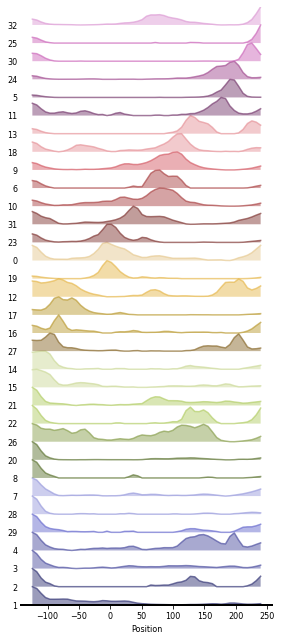

In [4]:
## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
active_epoch_times = sess.epochs['maze2'] 
# active_epoch_times = sess.epochs['maze1']  # array([11070, 13970], dtype=int64)
print('Constraining to epoch with times (start: {}, end: {})'.format(active_epoch_times[0], active_epoch_times[1]))

# spike_matrix, spike_cells, num_cells, spike_list, spike_positions_list, cell_ids, reverse_cellID_idx_lookup_map
active_epoch_session_Neurons = sess.neurons.get_neuron_type('pyr') # Filter by pyramidal cells only
active_epoch_session_Neurons = active_epoch_session_Neurons.time_slice(active_epoch_times[0], active_epoch_times[1]) # returns a core.Neurons object with its spiketrains filtered for the provided start/end times
active_epoch_position_times_index_mask = sess.position.time_slice_indicies(active_epoch_times[0], active_epoch_times[1]) # a Boolean selection mask
active_epoch_position_times = sess.position.time[active_epoch_position_times_index_mask] # The actual times
# active_epoch_time_indicies = np.flatnonzero(sess.position.time_slice_indicies(active_epoch_times[0], active_epoch_times[1]))
# active_epoch_time_indicies = np.where(sess.position.time_slice_indicies(active_epoch_times[0], active_epoch_times[1]))[0]
print('sess.position.t_start: {}'.format(sess.position.t_start))
# print('active_epoch_time_indicies: {}; shape: {}'.format(active_epoch_time_indicies, np.shape(active_epoch_time_indicies)))
print('active_epoch_position_times: {}; shape: {}'.format(active_epoch_position_times, np.shape(active_epoch_position_times)))
active_epoch_relative_position_times = active_epoch_position_times - active_epoch_position_times[0] # Subtract off the first index, so that it becomes zero
active_epoch_pos = sess.position.time_slice(active_epoch_times[0], active_epoch_times[1]) # active_epoch_pos's .time and start/end are all valid
print('active_epoch_relative_position_times: {}; shape: {}'.format(active_epoch_relative_position_times, np.shape(active_epoch_relative_position_times)))
# have active_epoch_position_times: the actual times each position sample occured in seconds, active_epoch_relative_position_times: the same as active_epoch_position_times but starting at zero. Finally, have a complete active_epoch_pos object

## Compute Placefields if needed:
from neuropy.analyses import Pf1D
should_force_recompute_placefields = True

try: active_epoch_placefields
except NameError: active_epoch_placefields = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
if ((active_epoch_placefields is None) or should_force_recompute_placefields):
    print('Recomputing active_epoch_placefields...')
    active_epoch_placefields = Pf1D(neurons=active_epoch_session_Neurons, position=active_epoch_pos.linear_pos_obj, speed_thresh=4, grid_bin=7)
    print('done.')
else:
    print('active_epoch_placefields already exists, reusing it')
    
# Get the cell IDs that have a good place field mapping:
good_placefield_neuronIDs = np.array(active_epoch_placefields.ratemap.neuron_ids) # in order of ascending ID
pf_ax, pf_sort_ind, pf_colors = active_epoch_placefields.plot_ratemaps()
pf_sort_ind = np.array([int(pf_sort_ind[i]) for i in np.arange(len(pf_sort_ind))]) # convert to integer scalar array
pf_sorted_good_placefield_neuronIDs = good_placefield_neuronIDs[pf_sort_ind]
# print('good_placefield_neuronIDs: {}\n pf_sort_ind: {}\n pf_sorted_good_placefield_neuronIDs: {}'.format(good_placefield_neuronIDs, pf_sort_ind, pf_sorted_good_placefield_neuronIDs))
# good_placefield_neuronIDs = good_placefield_neuronIDs[pf_sort_ind] # sort
reverse_color_sort_indices = np.argsort(pf_sort_ind)
# print('reverse_color_sort_indices: {}\n test_color_indicies: {}'.format(reverse_color_sort_indices, test_color_indicies))
# re-sort the colors array by the unitID
# print('shape of pf_colors: {}'.format(np.shape(pf_colors)))
pf_colors = pf_colors[:, reverse_color_sort_indices] # pf_colors shape is still (4, 31)
# print('new pf_colors: {}\n new shape of pf_colors: {}'.format(pf_colors, np.shape(pf_colors)))
active_epoch_session_Neurons = active_epoch_session_Neurons.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only

# Unpacking final values into separate variables:
# Spike variables:
num_cells = active_epoch_session_Neurons.n_neurons
spike_list = active_epoch_session_Neurons.spiketrains
cell_ids = active_epoch_session_Neurons.neuron_ids
flattened_spikes = active_epoch_session_Neurons.get_flattened_spikes() # get_flattened_spikes(..) returns a FlattenedSpiketrains object
# Position variables: t, x, y
t = active_epoch_pos.time
x = active_epoch_pos.x
y = active_epoch_pos.y
linear_pos = active_epoch_pos.linear_pos
# speeds = active_epoch_pos.speed # note this has 1 less element than active_epoch_pos.x

# Determine the x and y positions each spike occured for each cell
spike_positions_list = build_spike_positions_list(spike_list, t, x, y)
# print(np.shape(spike_positions_list[0]))
# print(np.shape(spike_positions_list[1]))
# flattened_spike_positions_list = np.concatenate(spike_positions_list)
# flattened_spike_positions_list = flattened_spike_positions_list[flattened_spikes.flattened_sort_indicies]
 # reverse_cellID_idx_lookup_map: Allows reverse indexing into the linear imported array using the original cell ID indicies
reverse_cellID_idx_lookup_map = build_cellID_reverse_lookup_map(cell_ids)
    
print('num_cells: {}'.format(num_cells))
print('cell_ids: {}'.format(cell_ids)) # cell_ids is now a regular python list with 57 elements

In [5]:
# print('spike_positions_list.shape: {}'.format(np.shape(spike_positions_list)))
# reverse_cellID_idx_lookup_map[2]
# active_cells_colormap = cc.rainbow[:num_cells]
active_cells_colormap = pf_colors.T
# active_cells_colormap
# print('{}'.format(cell_ids[0, 0]))
# Make the colormap from the listed colors
active_cells_listed_colormap = ListedColormap(active_cells_colormap)

In [6]:
# Gets the flattened spikes, sorted in ascending timestamp for all cells.
# flattened_spikes.flattened_spike_identities, flattened_spikes.flattened_spike_times

num_flattened_spikes = np.size(flattened_spikes.flattened_spike_times)
print('num_flattened_spikes: {}'.format(num_flattened_spikes))
# Build the Active UnitIDs
flattened_spike_active_unitIdentities = np.array([int(reverse_cellID_idx_lookup_map[original_cellID]) for original_cellID in flattened_spikes.flattened_spike_identities]) # since flattened_spikes.flattened_spike_identities is already sorted, don't double sort
# print(flattened_spike_active_unitIdentities)
## Build the flattened spike positions list
flattened_spike_positions_list = np.concatenate(tuple(spike_positions_list), axis=1) # needs tuple(...) to conver the list into a tuple, which is the format it expects
flattened_spike_positions_list = flattened_spike_positions_list[:, flattened_spikes.flattened_sort_indicies] # ensure the positions are ordered the same as the other flattened items so they line up
## TODO: WARNING: is using the t_fixedSegements in the plot function okay?
print('flattened_spike_positions_list: {}'.format(np.shape(flattened_spike_positions_list)))

num_flattened_spikes: 103801
flattened_spike_positions_list: (2, 103801)


In [7]:
from dataclasses import dataclass

@dataclass
class VisualizationWindow(object):
    """Docstring for VisualizationWindow."""
    duration_seconds: float
    duration_num_frames: int
    
    def build_sliding_windows(self, times):
        return VisualizationWindow.compute_sliding_windows(times, self.duration_num_frames)

    @staticmethod
    def compute_sliding_windows(times, num_window_frames):
        # build a sliding window to be able to retreive the correct flattened indicies for any given timestep
        from numpy.lib.stride_tricks import sliding_window_view
        return sliding_window_view(times, num_window_frames)
    
    
# have active_epoch_position_times: the actual times each position sample occured in seconds, active_epoch_relative_position_times: the same as active_epoch_position_times but starting at zero


# Split the position data into equal sized chunks to be displayed at a single time. These will look like portions of the trajectory and be used to animate. # Chunk the data to create the animation.
curr_plot_update_step = 1 # Update every other frame
curr_plot_update_frequency = curr_plot_update_step * active_epoch_pos.sampling_rate # number of updates per second (Hz)
num_time_points = active_epoch_pos.n_frames / curr_plot_update_step

print('active_epoch_pos.sampling_rate (Hz): {}'.format(active_epoch_pos.sampling_rate))

curr_window_duration = 2.5
curr_view_window_length_samples = int(np.floor(curr_window_duration * active_epoch_pos.sampling_rate)) # number of samples the window should last

recent_spikes_window = VisualizationWindow(duration_seconds=curr_window_duration, duration_num_frames=curr_view_window_length_samples)
# recent_spikes_window.duration_num_fra®®®mes
# curr_view_window_duration = 0.5 # last for 1/2 seconds
# curr_view_window_length_samples = curr_view_window_duration * active_epoch_pos.sampling_rate # number of samples the window should last
print('recent_spikes_window: {}'.format(recent_spikes_window))

# curr_view_window_length = 150 # View 5 seconds at a time (30fps)
# curr_view_window_length = 30 # View 5 seconds at a time (30fps)
# The original length 324574 / 30 = 10819
# t_fixedSegements,x_fixedSegements,y_fixedSegements,speeds_fixedSegements,dt_fixedSegements,dx_fixedSegements,dy_fixedSegements = process_chunk_equal_poritions_data(t, x, y, speeds, dt, dx, dy, curr_view_window_length)
# print('shapes - t_fixedSegements: {}, x_fixedSegements: {}, y_fixedSegements: {}'.format(np.shape(t_fixedSegements), np.shape(x_fixedSegements), np.shape(y_fixedSegements)))
# z_fixedSegements = np.zeros_like(x_fixedSegements)
# np.vstack(

from numpy.lib.stride_tricks import sliding_window_view
# build a sliding window to be able to retreive the correct flattened indicies for any given timestep
# v = sliding_window_view(t, recent_spikes_window.duration_num_frames)
active_epoch_position_linear_indicies = np.arange(np.size(active_epoch_position_times))
pre_computed_window_sample_indicies = recent_spikes_window.build_sliding_windows(active_epoch_position_linear_indicies)
print('pre_computed_window_sample_indicies: {}\n shape: {}'.format(pre_computed_window_sample_indicies, np.shape(pre_computed_window_sample_indicies)))
pre_computed_window_sample_indicies


## New Pre Computed Indicies Way:
z_fixed = np.full((recent_spikes_window.duration_num_frames,), 1.1)
# active_window_sample_indicies = np.squeeze(pre_computed_window_sample_indicies[i,:])
# t[active_window_sample_indicies], x[active_window_sample_indicies], y[active_window_sample_indicies]
# flattened_spike_active_unitIdentities[active_window_sample_indicies] # slightly above the zero plane to ensure it's above the flat map

# ## Old Way:
# data_vectors_matrix = np.vstack([t, x, y]) # pack the variables of interest into the data_vector_matrix
# outputMatrix_fixedSegements = process_chunk_equal_poritions_data_vectors(data_vectors_matrix, curr_view_window_length_samples)
# print('shape - outputMatrix_fixedSegements: {}'.format(np.shape(outputMatrix_fixedSegements)))
# num_data_vectors = np.shape(outputMatrix_fixedSegements)[0]
# # unpack the result
# t_fixedSegements, x_fixedSegements, y_fixedSegements = [np.squeeze(outputMatrix_fixedSegements[i,:,:]) for i in np.arange(num_data_vectors)]
# print('shapes - t_fixedSegements: {}, x_fixedSegements: {}, y_fixedSegements: {}'.format(np.shape(t_fixedSegements), np.shape(x_fixedSegements), np.shape(y_fixedSegements)))
# # z_fixedSegements = np.zeros_like(y_fixedSegements)
# z_fixedSegements = np.full_like(y_fixedSegements, 1.1) # slightly above the zero plane to ensure it's above the flat map



active_epoch_pos.sampling_rate (Hz): 60
recent_spikes_window: VisualizationWindow(duration_seconds=2.5, duration_num_frames=150)
pre_computed_window_sample_indicies: [[     0      1      2 ...    147    148    149]
 [     1      2      3 ...    148    149    150]
 [     2      3      4 ...    149    150    151]
 ...
 [194728 194729 194730 ... 194875 194876 194877]
 [194729 194730 194731 ... 194876 194877 194878]
 [194730 194731 194732 ... 194877 194878 194879]]
 shape: (194731, 150)


Based on frate_thresh, excluded neuron_ids: [8]
acitve_neuron_ids: [ 1  3 11 13 20 27 38 39 42 43 44 47 48 53 54 55 56 57 58 61 62 63 64 65
 68 70 75 77 87 91 93 95]


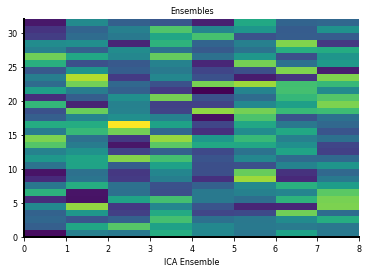

In [8]:
# p.app.focusWindow()
# p.app_window.isHidden()
# main_spikes_mesh

from neuropy.utils.mathutil import getICA_Assembly
#  (m x n) where 'm' are the number of cells and 'n' time bins
# getICA_Assembly(

from neuropy.analyses.reactivation import NeuronEnsembles
# active_epoch_placefields.frate_thresh
active_session_ensembles = NeuronEnsembles(active_epoch_session_Neurons, bin_size=0.250, frate_thresh=0.1)
active_session_ensembles.plot_ensembles()

# active_session_ensembles_neuron_ids = active_session_ensembles.neurons.neuron_ids
# removed_indicies = np.setdiff1d(active_epoch_session_Neurons, active_session_ensembles_neuron_ids, assume_unique=True) # returns the cellIDs that were removed 
active_neuron_ids_include_mask = active_session_ensembles.neuron_included_indx_thresh

print('acitve_neuron_ids: {}'.format(active_session_ensembles.neurons.neuron_ids))

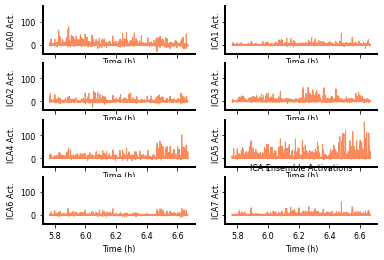

In [9]:
active_session_ensembles.calculate_activation()
active_session_ensembles.plot_activation()

In [11]:
# print('n_ensembles: {}'.format(active_session_ensembles.n_ensembles))
print('np.shape(weights): {}'.format(np.shape(active_session_ensembles.weights))) # shape (32, 8)
# np.shape(active_neuron_ids_include_mask) # (33,)
# np.shape(active_cells_colormap) # (33, 4)

np.shape(weights): (32, 8)


np.shape(template): (32, 12992), np.shape(zsc_template): (32, 12992)


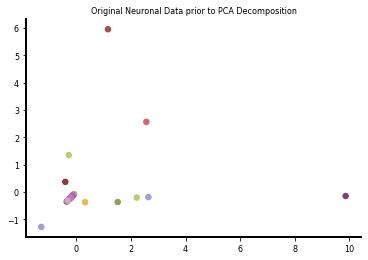

np.shape(pca_data): (32, 2)


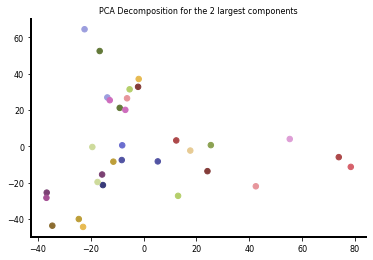

In [12]:
# Build the input matrix required for PCA
template, zsc_template = active_session_ensembles.get_original_data() # np.shape(template): (32, 12992)
print('np.shape(template): {}, np.shape(zsc_template): {}'.format(np.shape(template), np.shape(zsc_template)))
plt.figure()
plt.scatter(zsc_template[:, 0], zsc_template[:, 1], c=active_cells_colormap[active_neuron_ids_include_mask], s=30)
plt.title('Original Neuronal Data prior to PCA Decomposition')
plt.show()

from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 2 # project onto two dimensions
pca_data = pca.fit_transform(zsc_template)
print('np.shape(pca_data): {}'.format(np.shape(pca_data))) # np.shape(pca_data): (32, 2)
plt.figure()
# active_cells_colormap

# plt.scatter(pca_data[:, 0], pca_data[:, 1], c=zsc_template[:, 1], s=30, cmap=active_cells_colormap)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=active_cells_colormap[active_neuron_ids_include_mask, :], s=30)
plt.title('PCA Decomposition for the 2 largest components')
plt.show()

In [12]:
# should_use_test_batch_plotting_methods = True
should_use_test_batch_plotting_methods = False
should_use_new_precomputed_indicies_methods = True # Enable the newer analysis

# Video Output Settings:
active_is_video_output_mode = False
active_video_output_parent_dir = Path('output')
active_video_output_filename = 'complete_plotting_full_curve.mp4'
active_video_output_fullpath = active_video_output_parent_dir.joinpath(active_video_output_filename)

if should_use_new_precomputed_indicies_methods:
    num_time_points = active_epoch_pos.n_frames / curr_plot_update_step
else:
    num_time_points = np.shape(x_fixedSegements)[0]
print('num_time_points: {}\n'.format(num_time_points))
animal_location_sphere = pv.Sphere(radius=2.3)
animal_location_direction_cone = pv.Cone()
animal_location_circle = pv.Circle(radius=8.0)
animal_location_trail_circle = pv.Circle(radius=2.3)

## Spike indicator geometry:
# spike_geom = pv.Sphere(radius=0.2, phi_resolution=3, theta_resolution=3)
# spike_geom = pv.Arrow(direction=(0.0, 0.0, 1.0), shaft_resolution=8, scale=3)
spike_geom_cone = pv.Cone(direction=(0.0, 0.0, -1.0), height=10.0, radius=0.2)
spike_geom_circle = pv.Circle(radius=0.4)

#     animal_direction_arrow = pv.Arrow()
last_only_opacity_values = np.zeros([curr_view_window_length_samples,])
last_only_opacity_values[-1] = 1.0

# gradually_fading_opacity_values = np.arange(curr_view_window_length_samples)
gradually_fading_opacity_values = np.linspace(0.0, 1.0, curr_view_window_length_samples)
sharply_fading_opacity_values = np.linspace(0.0, 0.6, curr_view_window_length_samples)
# sharply_fading_opacity_values[-1] = 0.1 # last element (corresponding to current position) is set to 1.0

# active_trail_opacity_values = last_only_opacity_values.copy()
# active_trail_opacity_values = gradually_fading_opacity_values.copy()
active_trail_opacity_values = sharply_fading_opacity_values.copy()
# print('active_trail_opacity_values: {}\n'.format(np.shape(active_trail_opacity_values)))
# active_trail_size_values = np.full([curr_view_window_length_samples,], 0.6) # all have a scale of 0.6
active_trail_size_values = np.linspace(0.2, 0.6, curr_view_window_length_samples) # fade from a scale of 0.2 to 0.6
# active_trail_size_values[-1] = 6.0 # except for the end (current) point, which has a scale of 1.0
# active_trail_size_values = sharply_fading_opacity_values.copy()
## Slider with Callback Function Example:

def build_flat_map_plot_data():
    # Builds the flat base maze map that the other data will be plot on top of
    z = np.zeros_like(x)
    point_cloud = np.vstack((x, y, z)).T
    pdata = pv.PolyData(point_cloud)
    pdata['occupancy heatmap'] = np.arange(np.shape(point_cloud)[0])
    geo = pv.Circle(radius=0.5)
    pc = pdata.glyph(scale=False, geom=geo)
    return pdata, pc

# TODO: brought in from old file, finish implementation
def build_active_spikes_plot_data(active_flattened_spike_times, active_flattened_spike_identities, active_flattened_spike_positions_list, spike_geom):
    spike_series_times = active_flattened_spike_times # currently unused
    spike_series_identities = active_flattened_spike_identities # currently unused
    spike_series_positions = active_flattened_spike_positions_list
    # z = np.zeros_like(spike_series_positions[0,:])
    z_fixed = np.full_like(spike_series_positions[0,:], 1.1) # Offset a little bit in the z-direction so we can see it
    spike_history_point_cloud = np.vstack((spike_series_positions[0,:], spike_series_positions[1,:], z_fixed)).T
    spike_history_pdata = pv.PolyData(spike_history_point_cloud)
    # pdata['occupancy heatmap'] = np.arange(np.shape(point_cloud)[0])
#     pdata['occupancy heatmap'] = spike_series_times
    if should_use_test_batch_plotting_methods:
        spike_history_pdata['times'] = spike_series_times
    spike_history_pdata['cellID'] = spike_series_identities
    # create many spheres from the point cloud

    # spike_geom = spike_geom_cone.copy()
    spike_history_pc = spike_history_pdata.glyph(scale=False, geom=spike_geom)
#     pc['cellID'] = pdata['cellID']
    # # create many spheres from the point cloud
    # # sphere = pv.Sphere(radius=2.0, phi_resolution=3, theta_resolution=3)
    # spike_geom = pv.Arrow()
    # pc = pdata.glyph(scale=False, factor=0.0003, geom=spike_geom)
    return spike_history_pdata, spike_history_pc


######################
# General Plotting Method:    
def on_slider_update_mesh(value):
    curr_i = int(value)
    
    if should_use_new_precomputed_indicies_methods:
        active_window_sample_indicies = np.squeeze(pre_computed_window_sample_indicies[curr_i,:])
        # t[active_window_sample_indicies], x[active_window_sample_indicies], y[active_window_sample_indicies], flattened_spike_active_unitIdentities[active_window_sample_indicies]
        point_cloud_fixedSegements_positionTrail = np.column_stack((x[active_window_sample_indicies], y[active_window_sample_indicies], z_fixed))
    else:
        # Old way:
        point_cloud_fixedSegements_positionTrail = np.column_stack((x_fixedSegements[curr_i,:], y_fixedSegements[curr_i,:], z_fixedSegements[curr_i,:]))
        
#     print('point_cloud_fixedSegements_positionTrail: {}\n'.format(np.shape(point_cloud_fixedSegements_positionTrail)))
    curr_animal_point = point_cloud_fixedSegements_positionTrail[-1,:].copy() # Get the last point

    ## Spike Plotting:
    # Get the times that fall within the current plot window:
    if should_use_new_precomputed_indicies_methods:
        curr_time_fixedSegments = t[active_window_sample_indicies] # New Way
    else:
        curr_time_fixedSegments = t_fixedSegements[curr_i,:] # Old Way
        
    t_start = curr_time_fixedSegments[0]
    t_stop = curr_time_fixedSegments[-1]
    # print('Constraining to curr_time_fixedSegments with times (start: {}, end: {})'.format(t_start, t_stop))
    # print('curr_time_fixedSegments: {}'.format(curr_time_fixedSegments))
    curr_text_rendering_string = 'curr_i: {:d}; (t_start: {:.2f}, t_stop: {:.2f})'.format(curr_i, t_start, t_stop) # :.3f
    p.add_text(curr_text_rendering_string, name='lblCurrent_spike_range', position='lower_right', color='blue', shadow=True, font_size=12)
    
    ## New Batched/Ghosting Method for spikes plotting:
    if should_use_test_batch_plotting_methods:
        # New Method: Call to update the ghosts
        test_on_time_update_mesh(t_stop)
        pass
    else:
        # Find the flattened spikes corresponding to these times:
        # active_flattened_spike_identities  # actual UnitID is the identity for each spike
        # active_flattened_spike_identities # a relative index starting at 0 and going up to the number of active units is the identity for each spike
        
        ## Historical Spikes:
        active_included_all_historical_indicies = (flattened_spikes.flattened_spike_times < t_stop) # Accumulate Spikes mode. All spikes occuring prior to the end of the frame (meaning the current time) are plotted
        historical_spikes_pdata, historical_spikes_pc = build_active_spikes_plot_data(flattened_spikes.flattened_spike_times[active_included_all_historical_indicies], flattened_spike_active_unitIdentities[active_included_all_historical_indicies], flattened_spike_positions_list[:, active_included_all_historical_indicies], spike_geom=spike_geom_circle.copy())
        if historical_spikes_pc.n_points >= 1:
            historical_main_spikes_mesh = p.add_mesh(historical_spikes_pc, name='historical_spikes_main', scalars='cellID', cmap=active_cells_listed_colormap, show_scalar_bar=False, lighting=False, render=False)

        ## Actively Firing Spikes:
        active_included_recent_only_indicies = ((flattened_spikes.flattened_spike_times > t_start) & (flattened_spikes.flattened_spike_times < t_stop)) # Two Sided Range Mode
        recent_only_spikes_pdata, recent_only_spikes_pc = build_active_spikes_plot_data(flattened_spikes.flattened_spike_times[active_included_recent_only_indicies], flattened_spike_active_unitIdentities[active_included_recent_only_indicies], flattened_spike_positions_list[:, active_included_recent_only_indicies], spike_geom=spike_geom_cone.copy())
        if recent_only_spikes_pc.n_points >= 1:
            recent_only_main_spikes_mesh = p.add_mesh(recent_only_spikes_pc, name='recent_only_spikes_main', color='white', show_scalar_bar=False, lighting=False, render=False)

            
            
    ## Animal Position and Location Trail Plotting:
    pdata_positionTrail = pv.PolyData(point_cloud_fixedSegements_positionTrail) # a mesh
    pdata_positionTrail.point_data['pho_fade_values'] = active_trail_opacity_values
    pdata_positionTrail.point_data['pho_size_values'] = active_trail_size_values
    # create many spheres from the point cloud
    pc_positionTrail = pdata_positionTrail.glyph(scale='pho_size_values', geom=animal_location_trail_circle)
    # pc = pdata.glyph(scale='pho_size_values', geom=animal_location_sphere)
    
    # print('pdata.array_names: {}'.format(pdata.array_names))
    # print('pc.array_names: {}'.format(pc.array_names)) # pc.array_names: ['pho_size_values', 'pho_fade_values']
    
    # plines = p.add_lines(point_cloud_fixedSegements_positionTrail, name='animal_trajectory_lines', color='orange')
    # plines.point_data['pho_fade_values'] = active_trail_opacity_values
    #     p.add_mesh(pc, name='animal_location', color="red", opacity='linear', scalars='pho_fade_values', nan_opacity=0.0, use_transparency=True)
    # p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity=0.8, nan_opacity=0.0, use_transparency=True)
    # p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity="pho_fade_values", nan_opacity=0.0, use_transparency=True)

    animal_location_trail_mesh = p.add_mesh(pc_positionTrail, name='animal_location_trail', ambient=0.6, opacity='linear_r', scalars='pho_fade_values', nan_opacity=0.0, show_edges=False, render_lines_as_tubes=True, show_scalar_bar=False, use_transparency=True, render=False) # works to render a heat colored (most recent==hotter) position
    # animal_location_trail_mesh = p.add_mesh(pc, name='animal_location', color='white', ambient=0.6, opacity=1.0, nan_opacity=0.0, show_edges=False, render_lines_as_tubes=True, show_scalar_bar=False) # works to render a heat colored (most recent==hotter) position
    
    # Involves deep customization using VtkProperties. See https://vtk.org/doc/release/4.0/html/classvtkMapper.html#a18 :
    #  For more: https://www.programcreek.com/python/example/7857/vtk.vtkActor
    # animal_location_trail_mesh.GetProperty().SetColor([1.0, 0.0, 0.0]) # Working, so long as scalars isn't set
    # animal_location_trail_mesh.GetProperty().SetOpacity('pho_fade_values') #
    # animal_location_trail_mesh.GetMapper().GetColorModeAsString() # should return the current color mode (like whether color is set by a property, or from the scalars, etc)
    # print('animal_location_trail_mesh.GetMapper().GetColorModeAsString(): {}'.format(animal_location_trail_mesh.GetMapper().GetColorModeAsString())) # when scalars are set, returns "MapScalars" otherwise returns "Default"
    
    ## Fixes the problem of the scalars determining the object's color when I don't want them to:
    # animal_location_trail_mesh.GetMapper().ScalarVisibilityOff() # Scalars not used to color objects
    
    ## Animal Current Position:
    pdata_current_point = pv.PolyData(curr_animal_point) # a mesh
    pc_current_point = pdata_current_point.glyph(scale=False, geom=animal_location_circle)
    animal_current_location_point_mesh = p.add_mesh(pc_current_point, name='animal_location', color='white', ambient=0.6, opacity=0.5, show_edges=True, nan_opacity=0.0, render_lines_as_tubes=True, show_scalar_bar=False, use_transparency=True, render=False) # works to render a heat colored (most recent==hotter) position
    
    p.render() # renders to ensure it's updated after changing the ScalarVisibility above
    # p.app.processEvents() # not needed probably
    return

# Only Create a new BackgroundPlotter if it's needed:
if (active_is_video_output_mode):
    ## Video mode should use a regular plotter object
    # p = pv.Plotter() # Use just like you would a pv.Plotter() instance
    p = pv.Plotter(notebook=False, window_size=([1920, 1080]), off_screen=True) # , line_smoothing=True, polygon_smoothing=True, multi_samples=8
else:
    try: p
    except NameError: p = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
    if ((p is None) or p.app_window.isHidden()):
        print('No open BackgroundPlotter. Creating a new one')
        p = pvqt.BackgroundPlotter(window_size=(1920, 1080), off_screen=False) # Use just like you would a pv.Plotter() instance
    else:
        print('BackgroundPlotter already open, reusing it')
        p.app_window.window().show()
        p.clear()

        
# p.background_color = 'black'
if should_use_test_batch_plotting_methods:
    # main_spikes_mesh = test_batch_plot_all_spikes()
    main_spikes_mesh, main_spikes_mesh_actor = test_batch_plot_all_spikes()
    
if (not active_is_video_output_mode):
    p.add_slider_widget(on_slider_update_mesh, [0, (num_time_points-1)], title='Trajectory Timestep', event_type='always', style='modern')
                  
pdata_maze, pc_maze = build_flat_map_plot_data()
# Plot the flat arena
p.add_mesh(pc_maze, name='maze_bg', color="black", render=False)

# p.add_bounding_box()
# p.show_grid()
# p.add_axes(line_width=5, labels_off=True)
p.hide_axes()
p.camera_position = 'xy' # Overhead (top) view
p.render() # manually render when needed

if active_is_video_output_mode:
    print('Writing video to {}...'.format(active_video_output_fullpath))
    # active_frame_range = np.arange(num_time_points) # All frames
    # active_frame_range = np.arange(num_time_points) # All frames
    # active_frame_range = np.arange(153235, (153235 + 100)) # Only 100 frames
        
    # curr_i: 1100 to 3777
    # t_start: 20774.40 to 20818.95
    active_frame_range = np.arange(1100, 3777) # Only 100 frames
    # active_frame_range = range(100) # Only 100 frames
    p.show(auto_close=False)
    make_mp4_from_plotter(p, active_frame_range, on_slider_update_mesh, filename=active_video_output_fullpath)
    p.close()

# p.show()
                  
print('all done!')

num_time_points: 194880.0

No open BackgroundPlotter. Creating a new one
all done!


In [ ]:
p.app_window.window().show()

In [ ]:
p.off_screen

In [ ]:
p1 = pv.Plotter(window_size=([1920, 1080]), off_screen=True, line_smoothing=True, polygon_smoothing=True, multi_samples=8)
print('isinstance(p1, pvqt.BackgroundPlotter): {}'.format(isinstance(p1, pvqt.BackgroundPlotter)))
print('isinstance(p1, pv.plotting.Plotter): {}'.format(isinstance(p1, pv.plotting.Plotter)))
p1.close()

In [ ]:
p2 = pvqt.BackgroundPlotter(window_size=(1920, 1080), off_screen=True) # pyvistaqt.plotting.BackgroundPlotter
print('isinstance(p2, pvqt.BackgroundPlotter): {}'.format(isinstance(p2, pvqt.BackgroundPlotter)))
print('isinstance(p2, pv.plotting.Plotter): {}'.format(isinstance(p2, pv.plotting.Plotter)))
# isinstance(p2, pvqt.plotting.BackgroundPlotter)

In [ ]:
isinstance(p1, pv.plotting.Plotter)